# **Reinforcement Learning: Taller 4**
## Juan Pablo Reyes Fajardo y Santiago Rodríguez Ávila 

## Importación de módulos

In [38]:
!pip -q install tqdm
import gym
import random
import numpy as np
import itertools
import operator
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

from keras.models import Sequential,clone_model
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.callbacks import Callback

## Funciones auxiliares

In [2]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [3]:
# Funcion Auxiliar para diccionarios
def key_max(d):
        return max(d.items(), key=operator.itemgetter(1))
def key_min(d):
        return min(d.items(), key=operator.itemgetter(1))

## Creación del ambiente

In [4]:
env = gym.make('CartPole-v1')

## 1. RL Tabular

Experimentos a promediar

In [5]:
experimentos=5
episodios_aprendizaje=int(2e4)

Política $\epsilon$ - Greedy 

(Útil más adelante)

In [6]:
def eps_greedy(Q_, state,epsilon=0.1):
    rand = np.random.uniform()
    if rand>epsilon:
        return key_max(Q_[state])[0],1-epsilon
    else:
        return random.choice(list(Q_[state])),epsilon

### Discretización

Inicialmente se realizan múltiples (1 millón) experimentos para determinar límites razonables para las variables a discretizar (aquellas cuyo espacio de observación es infinito)

In [7]:
velocidades_absolutas_maximas={"Lineal":[],"Angular":[]}

observation = env.reset()

abs_lineal=abs(observation[1])
abs_angular=abs(observation[3])

for _ in range(int(1e6)):
    
    action = env.action_space.sample() 
    observation, reward, terminated, truncated = env.step(action)
    
    if abs(observation[1])>abs_lineal:
        abs_lineal=abs(observation[1])
    if abs(observation[3])>abs_angular:
        abs_angular=abs(observation[3])

    if terminated or truncated:
        observation= env.reset()
        velocidades_absolutas_maximas["Lineal"].append(abs_lineal)
        velocidades_absolutas_maximas["Angular"].append(abs_angular)


vel_lin_abs_max=np.mean(velocidades_absolutas_maximas["Lineal"])
vel_ang_abs_max=np.mean(velocidades_absolutas_maximas["Angular"])
print(f'Promedio de velocidad lineal absoluta máxima: \
      {vel_lin_abs_max} \
      \nPromedio de velocidad angular absoluta máxima: \
      {vel_ang_abs_max}')

Promedio de velocidad lineal absoluta máxima:       3.4285038486789183       
Promedio de velocidad angular absoluta máxima:       3.4788269924781425


Discretización de estados:

In [8]:
# Límites del espacio de observación del MDP real
cart_high_var = env.observation_space.high
cart_low_var = env.observation_space.low

# Espacios de observación discretizados
observation_space_discrete_400=[np.linspace(cart_low_var[0], cart_high_var[0], num= 5),\
                            np.linspace(-vel_lin_abs_max, vel_lin_abs_max, num= 4),\
                            np.linspace(cart_low_var[2], cart_high_var[2], num = 5),\
                            np.linspace(-vel_ang_abs_max, vel_ang_abs_max, num= 4)]\

observation_space_discrete_4096=[np.linspace(cart_low_var[0], cart_high_var[0], num= 8),\
                            np.linspace(-vel_lin_abs_max, vel_lin_abs_max, num= 8),\
                            np.linspace(cart_low_var[2], cart_high_var[2], num = 8),\
                            np.linspace(-vel_ang_abs_max, vel_ang_abs_max, num= 8)]

# Uso de iteradores para obtener todos los estados a partir del espacio de obsevación discreto
states_400=list(itertools.product(*observation_space_discrete_400))
states_4096=list(itertools.product(*observation_space_discrete_4096))

# Retorna un diccionario Q, inicializado en 0 para todo par (S,A), para la discretización de 400 estados
def init_Q_400():
    Q_table={}
    for i in states_400:
        Q_table[i] = {0:0,1:0}
    return Q_table

# Retorna un diccionario Q, inicializado en 0 para todo par (S,A),  para la discretización de 4096 estados
def init_Q_4096():
    Q_table={}
    for i in states_4096:
        Q_table[i] = {0:0,1:0}
    return Q_table

# Inicializa una política para todos los estados en la discretización de 400 estados
def init_policy_400():
    return dict.fromkeys(states_400, 0)

# Inicializa una política para todos los estados en la discretización de 400 estados
def init_policy_4096():
    return dict.fromkeys(states_4096, 0)

# Convierte un estado del ambiente en un estado discreto, usando la discretización de 400 estados
def discretize_400(new_state):
    discretizacion=[0]*4
    for i in range(len(discretizacion)):
        dif = [(abs(x - new_state[i])) for x in observation_space_discrete_400[i]]
        discretizacion[i] = observation_space_discrete_400[i][dif.index(min(dif))]
        
    return tuple(discretizacion)

# Convierte un estado del ambiente en un estado discreto, usando la discretización de 400 estados
def discretize_4096(new_state):
    discretizacion=[0]*4
    for i in range(len(discretizacion)):
        dif = [(abs(x - new_state[i])) for x in observation_space_discrete_4096[i]]
        discretizacion[i] = observation_space_discrete_4096[i][dif.index(min(dif))]
        
    return tuple(discretizacion)

### Estimación de Q con Q-Learning 
Implementación del algoritmo de Q-Learning

#### Algoritmo 400 Estados

In [9]:
def Q_Learning_400(Q,gamma=0.9,alpha=0.01,epsilon=0.1):
    
    G=0
    terminated,truncated=False,False
    
    observation = env.reset()
    observation=discretize_400(observation)
    
    while not (terminated or truncated):
        action,_=eps_greedy(Q,observation,epsilon)
        
        observation_, reward, terminated, truncated = env.step(action)
        observation_=discretize_400(observation_)
        
        G+=reward
        
        if terminated or truncated:
            Q_=0
        else:
            Q_=key_max(Q[observation_])[1]
        
        Q[observation][action]+=alpha*(reward+gamma*Q_-Q[observation][action])
        observation=observation_
        
    return Q,G

#### Algoritmo 4096 Estados

In [10]:
def Q_Learning_4096(Q,gamma=0.9,alpha=0.01,epsilon=0.1):
    G=0
    terminated,truncated=False,False
    
    observation = env.reset()
    observation=discretize_4096(observation)
    
    while not (terminated or truncated):
        action,_=eps_greedy(Q,observation,epsilon)
        
        observation_, reward, terminated, truncated = env.step(action)
        observation_=discretize_4096(observation_)
        
        G+=reward
        
        if terminated or truncated:
            Q_=0
        else:
            Q_=key_max(Q[observation_])[1]
        
        Q[observation][action]+=alpha*(reward+gamma*Q_-Q[observation][action])
        observation=observation_
        
    return Q,G
        

##### Aprendizaje 400 estados

In [11]:
Gs_400_Qlearn=[]

for i in range(experimentos):
    Q_400_Qlearn=init_Q_400()
    Gs_experimento=[]
    for i in tqdm(range(episodios_aprendizaje)):
        Q_400_Qlearn,G=Q_Learning_400(Q_400_Qlearn)
        Gs_experimento.append(G)
    Gs_400_Qlearn.append(Gs_experimento)

100%|██████████| 20000/20000 [01:25<00:00, 233.87it/s]


#### Aprendizaje 4096 estados

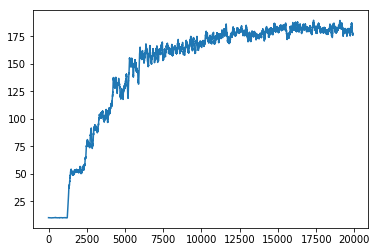

In [12]:
plt.plot(running_mean(np.mean(Gs_400_Qlearn,axis=0),100))

In [13]:
Gs_4096_Qlearn=[]

for i in range(experimentos):
    Q_4096_Qlearn=init_Q_4096()
    Gs_experimento=[]
    for i in tqdm(range(episodios_aprendizaje)):
        Q_4096_Qlearn,G=Q_Learning_4096(Q_4096_Qlearn)
        Gs_experimento.append(G)
    Gs_4096_Qlearn.append(Gs_experimento)

100%|██████████| 20000/20000 [00:53<00:00, 374.58it/s]


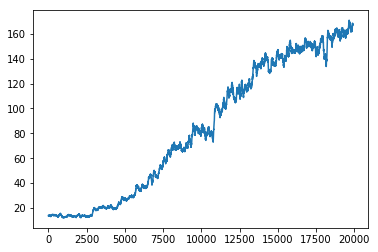

In [14]:
plt.plot(running_mean(np.mean(Gs_4096_Qlearn,axis=0),100))

#### Política usando greedy respecto a Q para la discretización de 400 estados

In [15]:
policy_400_Qlearn=init_policy_400()
for state_400 in states_400:
    policy_400_Qlearn[state_400],_=eps_greedy(Q_400_Qlearn,tuple(state_400),0)

#### Política usando greedy respecto a Q para la discretización de 4096 estados

In [16]:
policy_4096_Qlearn=init_policy_4096()
for state_4096 in states_4096:
    policy_4096_Qlearn[state_4096],_=eps_greedy(Q_4096_Qlearn,tuple(state_4096),0)

 #### Evaluación de política para la discretización de 400 estados

In [17]:
rwds=[]
for _ in range(100):
    observation = env.reset()
    r=0
    while True:
        time.sleep(0.0001)
        action = policy_400_Qlearn[discretize_400(observation)]
        env.render(mode = "human")
        observation, reward, terminated, truncated = env.step(action)
        r+=reward

        if terminated or truncated:
            observation = env.reset()
            rwds.append(r)
            break
env.close()
print("Recompensas promedio para 400 estados: ",np.mean(rwds))

Recompensas promedio para 400 estados:  189.92


 #### Evaluación de política para la discretización de 4096 estados

In [18]:
rwds=[]
for _ in range(100):
    observation = env.reset()
    r=0
    while True:
        time.sleep(0.0001)
        action = policy_4096_Qlearn[discretize_4096(observation)]
        env.render(mode = "human")
        observation, reward, terminated, truncated = env.step(action)
        r+=reward

        if terminated or truncated:
            observation = env.reset()
            rwds.append(r)
            break
env.close()
print("Recompensas promedio para 4096 estados: ",np.mean(rwds))

Recompensas promedio para 4096 estados:  180.86


### Estimación de Q con SARSA
Implementación del algoritmo SARSA

#### Algoritmo 400 Estados

In [19]:
def SARSA_400(Q,gamma=0.9,alpha=0.01,epsilon=0.1):
    
    G=0
    terminated,truncated=False,False
    
    observation = env.reset()
    observation=discretize_400(observation)
    action,_=eps_greedy(Q,observation,epsilon)
    
    while not (terminated or truncated):
        
        
        observation_, reward, terminated, truncated = env.step(action)
        observation_=discretize_400(observation_)
        action_,_ = eps_greedy(Q,observation_,epsilon)
        
        G+=reward
        
        if terminated or truncated:
            Q_=0
        else:
            Q_=Q[observation_][action_]
        
        Q[observation][action]+=alpha*(reward+gamma*Q_-Q[observation][action])
        observation=observation_
        action = action_
        
    return Q,G

#### Algoritmo 4096 Estados

In [20]:
def SARSA_4096(Q,gamma=0.9,alpha=0.01,epsilon=0.1):
    G=0
    terminated,truncated=False,False
    
    observation = env.reset()
    observation=discretize_4096(observation)
    action,_=eps_greedy(Q,observation,epsilon)
    
    while not (terminated or truncated):
        
        
        observation_, reward, terminated, truncated = env.step(action)
        observation_=discretize_4096(observation_)
        action_,_ = eps_greedy(Q,observation_,epsilon)
        
        G+=reward
        
        if terminated or truncated:
            Q_=0
        else:
            Q_=Q[observation_][action_]
        
        Q[observation][action]+=alpha*(reward+gamma*Q_-Q[observation][action])
        observation=observation_
        action = action_
    return Q,G
        

##### Aprendizaje 400 estados

In [21]:
Gs_400_SARSA=[]

for i in range(experimentos):
    Q_400_SARSA=init_Q_400()
    Gs_experimento=[]
    for i in tqdm(range(episodios_aprendizaje)):
        Q_400_SARSA,G=SARSA_400(Q_400_SARSA)
        Gs_experimento.append(G)
    Gs_400_SARSA.append(Gs_experimento)

100%|██████████| 20000/20000 [01:21<00:00, 244.58it/s]


#### Aprendizaje 4096 estados

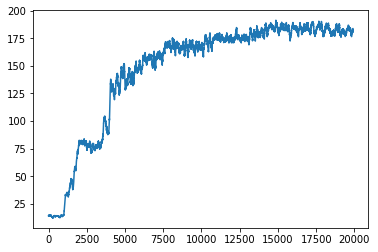

In [22]:
plt.plot(running_mean(np.mean(Gs_400_SARSA,axis=0),100))

In [23]:
Gs_4096_SARSA=[]

for i in range(experimentos):
    Q_4096_SARSA=init_Q_4096()
    Gs_experimento=[]
    for i in tqdm(range(episodios_aprendizaje)):
        Q_4096_SARSA,G=SARSA_4096(Q_4096_SARSA)
        Gs_experimento.append(G)
    Gs_4096_SARSA.append(Gs_experimento)

100%|██████████| 20000/20000 [00:50<00:00, 397.29it/s]


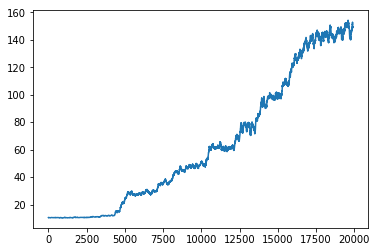

In [24]:
plt.plot(running_mean(np.mean(Gs_4096_SARSA,axis=0),100))

#### Política usando greedy respecto a Q para la discretización de 400 estados

In [25]:
policy_400_SARSA=init_policy_400()
for state_400 in states_400:
    policy_400_SARSA[state_400],_=eps_greedy(Q_400_SARSA,tuple(state_400),0)

#### Política usando greedy respecto a Q para la discretización de 4096 estados

In [26]:
policy_4096_SARSA=init_policy_4096()
for state_4096 in states_4096:
    policy_4096_SARSA[state_4096],_=eps_greedy(Q_4096_SARSA,tuple(state_4096),0)

 #### Evaluación de política para la discretización de 400 estados

In [27]:
rwds=[]
for _ in range(100):
    observation = env.reset()
    r=0
    while True:
        time.sleep(0.0001)
        action = policy_400_SARSA[discretize_400(observation)]
        env.render(mode = "human")
        observation, reward, terminated, truncated = env.step(action)
        r+=reward

        if terminated or truncated:
            observation = env.reset()
            rwds.append(r)
            break
env.close()
print("Recompensas promedio para 400 estados: ",np.mean(rwds))

Recompensas promedio para 400 estados:  201.37


 #### Evaluación de política para la discretización de 4096 estados

In [28]:
rwds=[]
for _ in range(100):
    observation = env.reset()
    r=0
    while True:
        time.sleep(0.0001)
        action = policy_4096_SARSA[discretize_4096(observation)]
        env.render(mode = "human")
        observation, reward, terminated, truncated = env.step(action)
        r+=reward

        if terminated or truncated:
            observation = env.reset()
            rwds.append(r)
            break
env.close()
print("Recompensas promedio para 4096 estados: ",np.mean(rwds))

Recompensas promedio para 4096 estados:  202.55


## 2. Aproximación de Funciones

Clase auxiliar para obtener las recompensas por episodio

In [46]:
class EpisodeRewardCallback(Callback):
    def __init__(self):
        super(EpisodeRewardCallback, self).__init__()
        self.episode_rewards = []

    def on_episode_end(self, episode, logs):
        episode_reward = logs['episode_reward']
        self.episode_rewards.append(episode_reward)
        print(f"Episode {episode + 1} reward: {episode_reward}")
        
episode_callback_DQN_4  = EpisodeRewardCallback()
episode_callback_DQN_16  = EpisodeRewardCallback()
episode_DSARSA_4  = EpisodeRewardCallback()
episode_DSARSA_16  = EpisodeRewardCallback()

### Construcción de aproximadores

In [47]:
model_DQN_4 = Sequential()
model_DQN_4.add(Flatten(input_shape=(1,) + env.observation_space.shape))
model_DQN_4.add(Dense(4))
model_DQN_4.add(Activation('relu'))
model_DQN_4.add(Dense(env.action_space.n))
model_DQN_4.add(Activation('linear'))

model_DQN_16 = Sequential()
model_DQN_16.add(Flatten(input_shape=(1,) + env.observation_space.shape))
model_DQN_16.add(Dense(16))
model_DQN_16.add(Activation('relu'))
model_DQN_16.add(Dense(env.action_space.n))
model_DQN_16.add(Activation('linear'))

model_DSARSA_4=clone_model(model_DQN_4)

model_DSARSA_16=clone_model(model_DQN_16)

### Memoria de los modelos

In [43]:
memory_DQN_4  = SequentialMemory(limit=episodios_aprendizaje, window_length=1)
memory_DQN_16  = SequentialMemory(limit=episodios_aprendizaje, window_length=1)
memory_DSARSA_4  = SequentialMemory(limit=episodios_aprendizaje, window_length=1)
memory_DSARSA_16 = SequentialMemory(limit=episodios_aprendizaje, window_length=1)

### Política

In [ ]:
policy = EpsGreedyQPolicy()

### Agentes

In [44]:
DQN_4 = DQNAgent(model=model_DQN_4, nb_actions=nb_actions, memory=memory_DQN_4,target_model_update=1e-2, policy=policy)
DQN_16 = DQNAgent(model=model_DQN_16, nb_actions=nb_actions, memory=memory_DQN_16,target_model_update=1e-2, policy=policy)
DSARSA_4 = DQNAgent(model=model_DSARSA_4, nb_actions=nb_actions, memory=memory_DSARSA_4,target_model_update=1e-2, policy=policy)
DSARSA_16 = DQNAgent(model=model_DSARSA_16, nb_actions=nb_actions, memory=memory_DSARSA_16,target_model_update=1e-2, policy=policy)

### Compilación

In [45]:
DQN_4.compile(Adam(), metrics=['mae'])
DQN_16.compile(Adam(), metrics=['mae'])
DSARSA_4.compile(Adam(), metrics=['mae'])
DSARSA_16.compile(Adam(), metrics=['mae'])

### Entrenamiento

In [48]:
DQN_4.fit(env, nb_steps=episodios_aprendizaje, visualize=False, callbacks=[episode_callback_DQN_4])
DQN_16.fit(env, nb_steps=episodios_aprendizaje, visualize=False, callbacks=[episode_callback_DQN_16])
DSARSA_4.fit(env, nb_steps=episodios_aprendizaje, visualize=False, callbacks=[episode_DSARSA_4])
DSARSA_16.fit(env, nb_steps=episodios_aprendizaje, visualize=False, callbacks=[episode_DSARSA_16])

Training for 20000 steps ...
Interval 1 (0 steps performed)
 2081/10000 [=====>........................] - ETA: 38s - reward: 1.0000Episode 85 reward: 18.0


 3019/10000 [========>.....................] - ETA: 38s - reward: 1.0000Episode 170 reward: 12.0


 3901/10000 [==========>...................] - ETA: 35s - reward: 1.0000Episode 254 reward: 10.0


 7586/10000 [=====================>........] - ETA: 14s - reward: 1.0000Episode 338 reward: 93.0


10000/10000 [==============================] - 62s 6ms/step - reward: 1.0000
383 episodes - episode_reward: 25.966 [8.000, 212.000] - loss: 3.036 - mean_absolute_error: 7.444 - mean_q: 13.865

Interval 2 (10000 steps performed)
 1977/10000 [====>.........................] - ETA: 50s - reward: 1.0000 ETA: 50s - reward: 1.00Episode 420 reward: 40.0


10000/10000 [==============================] - 63s 6ms/step - reward: 1.0000
done, took 124.807 seconds
Training for 20000 steps ...
Interval 1 (0 steps performed)
  108/10000 [..............................] - ETA: 26s - reward: 1.0000Episode 3 reward: 24.0
Episode 4 reward: 31.0
  193/10000 [..............................] - ETA: 20s - reward: 1.0000Episode 6 reward: 28.0


  543/10000 [>.............................] - ETA: 16s - reward: 1.0000Episode 16 reward: 23.0
Episode 17 reward: 22.0
  617/10000 [>.............................] - ETA: 16s - reward: 1.0000Episode 18 reward: 52.0
Episode 19 reward: 31.0
  695/10000 [=>............................] - ETA: 15s - reward: 1.0000Episode 20 reward: 39.0
Episode 21 reward: 29.0
 3701/10000 [==========>...................] - ETA: 35s - reward: 1.0000Episode 93 reward: 15.0


 6353/10000 [==================>...........] - ETA: 22s - reward: 1.0000Episode 177 reward: 23.0


10000/10000 [==============================] - 62s 6ms/step - reward: 1.0000
227 episodes - episode_reward: 43.167 [13.000, 312.000] - loss: 2.858 - mean_absolute_error: 9.799 - mean_q: 19.297

Interval 2 (10000 steps performed)
 8203/10000 [=======================>......] - ETA: 11s - reward: 1.0000Episode 258 reward: 201.0


10000/10000 [==============================] - 63s 6ms/step - reward: 1.0000
done, took 124.224 seconds
Training for 20000 steps ...
Interval 1 (0 steps performed)
   37/10000 [..............................] - ETA: 52s - reward: 1.0000  Episode 1 reward: 40.0
Episode 2 reward: 25.0
  187/10000 [..............................] - ETA: 20s - reward: 1.0000Episode 6 reward: 28.0
Episode 7 reward: 22.0
  638/10000 [>.............................] - ETA: 14s - reward: 1.0000Episode 19 reward: 34.0
Episode 20 reward: 25.0
  791/10000 [=>............................] - ETA: 14s - reward: 1.0000Episode 23 reward: 37.0
Episode 24 reward: 18.0
 2795/10000 [=======>......................] - ETA: 35s - reward: 1.0000Episode 81 reward: 23.0


 5835/10000 [================>.............] - ETA: 24s - reward: 1.0000Episode 165 reward: 26.0


 9555/10000 [===========================>..] - ETA: 2s - reward: 1.0000Episode 250 reward: 46.0


10000/10000 [==============================] - 61s 6ms/step - reward: 1.0000
262 episodes - episode_reward: 38.137 [12.000, 169.000] - loss: 3.883 - mean_absolute_error: 9.170 - mean_q: 17.702

Interval 2 (10000 steps performed)
 1995/10000 [====>.........................] - ETA: 52s - reward: 1.0000Episode 332 reward: 29.0


 4174/10000 [===========>..................] - ETA: 39s - reward: 1.0000Episode 416 reward: 41.0


 7470/10000 [=====================>........] - ETA: 16s - reward: 1.0000Episode 500 reward: 53.0


10000/10000 [==============================] - 66s 7ms/step - reward: 1.0000
done, took 127.310 seconds
Training for 20000 steps ...
Interval 1 (0 steps performed)
   69/10000 [..............................] - ETA: 36s - reward: 1.0000Episode 2 reward: 33.0
Episode 3 reward: 21.0
  230/10000 [..............................] - ETA: 19s - reward: 1.0000Episode 6 reward: 29.0
Episode 7 reward: 25.0
  346/10000 [>.............................] - ETA: 17s - reward: 1.0000Episode 10 reward: 35.0
Episode 11 reward: 21.0
  534/10000 [>.............................] - ETA: 15s - reward: 1.0000Episode 14 reward: 50.0
Episode 15 reward: 29.0
  697/10000 [=>............................] - ETA: 14s - reward: 1.0000Episode 17 reward: 64.0
Episode 18 reward: 29.0
 1450/10000 [===>..........................] - ETA: 33s - reward: 1.0000Episode 47 reward: 9.0


 2982/10000 [=======>......................] - ETA: 37s - reward: 1.0000Episode 132 reward: 13.0


10000/10000 [==============================] - 61s 6ms/step - reward: 1.0000
202 episodes - episode_reward: 48.342 [9.000, 283.000] - loss: 4.670 - mean_absolute_error: 11.358 - mean_q: 22.369

Interval 2 (10000 steps performed)
 2458/10000 [======>.......................] - ETA: 48s - reward: 1.0000Episode 214 reward: 138.0


10000/10000 [==============================] - 65s 6ms/step - reward: 1.0000
done, took 125.870 seconds


In [37]:


# After training is done, we save the final weights.
dqn.save_weights('dqn_{}_weights.h5f'.format(ENV_NAME), overwrite=True)

# Finally, evaluate our algorithm for 5 episodes.
dqn.test(env, nb_episodes=5, visualize=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 4)                 0         
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 20        
_________________________________________________________________
activation_9 (Activation)    (None, 4)                 0         
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 10        
_________________________________________________________________
activation_10 (Activation)   (None, 2)                 0         
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________
None
Training for 20000 steps ...
Interval 1 (0 steps performed)
    1/10000 [..............................] - ETA: 26:31 - reward: 1.0000Episode

/opt/conda/lib/python3.6/site-packages/rl/memory.py:39: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


  845/10000 [=>............................] - ETA: 1:09 - reward: 1.0000Episode 86 reward: 8.0


 1690/10000 [====>.........................] - ETA: 59s - reward: 1.0000Episode 170 reward: 13.0


 2696/10000 [=======>......................] - ETA: 50s - reward: 1.0000Episode 254 reward: 14.0


 4025/10000 [===========>..................] - ETA: 40s - reward: 1.0000Episode 338 reward: 10.0


 5684/10000 [================>.............] - ETA: 28s - reward: 1.0000Episode 422 reward: 35.0


 9792/10000 [============================>.] - ETA: 1s - reward: 1.0000Episode 506 reward: 51.0


10000/10000 [==============================] - 62s 6ms/step - reward: 1.0000
510 episodes - episode_reward: 19.557 [8.000, 272.000] - loss: 1.690 - mean_absolute_error: 5.572 - mean_q: 10.522

Interval 2 (10000 steps performed)
 3976/10000 [==========>...................] - ETA: 34s - reward: 1.0000Episode 588 reward: 128.0


10000/10000 [==============================] - 58s 6ms/step - reward: 1.0000
done, took 120.801 seconds
Testing for 5 episodes ...
Episode 1: reward: 119.000, steps: 119
Episode 2: reward: 102.000, steps: 102
Episode 3: reward: 138.000, steps: 138
Episode 4: reward: 72.000, steps: 72
Episode 5: reward: 78.000, steps: 78


In [27]:
print("All episode rewards:", episode_callback.episode_rewards)

All episode rewards: [82.0, 33.0, 52.0, 41.0, 56.0, 40.0, 43.0, 42.0, 38.0, 30.0, 44.0, 47.0, 54.0, 49.0, 31.0, 24.0, 58.0, 55.0, 25.0, 19.0, 16.0, 20.0, 16.0, 18.0, 24.0, 12.0, 18.0, 13.0, 15.0, 15.0, 17.0, 13.0, 16.0, 12.0, 12.0, 14.0, 15.0, 10.0, 15.0, 15.0, 11.0, 13.0, 11.0, 13.0, 11.0, 10.0, 12.0, 11.0, 10.0, 13.0, 11.0, 13.0, 15.0, 12.0, 10.0, 12.0, 11.0, 11.0, 9.0, 15.0, 10.0, 13.0, 14.0, 12.0, 13.0, 12.0, 13.0, 10.0, 11.0, 12.0, 10.0, 9.0, 11.0, 9.0, 10.0, 11.0, 13.0, 11.0, 11.0, 12.0, 12.0, 12.0, 13.0, 12.0, 11.0, 11.0, 16.0, 16.0, 13.0, 16.0, 14.0, 14.0, 16.0, 13.0, 10.0, 13.0, 15.0, 12.0, 12.0, 14.0, 14.0, 15.0, 16.0, 12.0, 18.0, 18.0, 16.0, 16.0, 11.0, 14.0, 14.0, 18.0, 14.0, 12.0, 12.0, 12.0, 18.0, 18.0, 19.0, 24.0, 17.0, 13.0, 20.0, 13.0, 17.0, 20.0, 19.0, 14.0, 13.0, 15.0, 18.0, 17.0, 18.0, 17.0, 22.0, 18.0, 24.0, 22.0, 17.0, 30.0, 20.0, 28.0, 14.0, 21.0, 18.0, 35.0, 43.0, 29.0, 69.0, 40.0, 35.0, 29.0, 31.0, 36.0, 37.0, 65.0, 36.0, 53.0, 27.0, 77.0, 55.0, 106.0, 30.0, 79

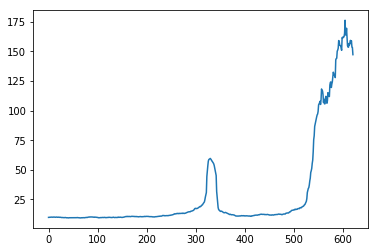

In [36]:
import matplotlib.pyplot as plt
plt.plot(running_mean(episode_callback.episode_rewards,20))
plt.show()

In [ ]:
#SARSA algorithm
def SARSA_algorithm(num_episodes):
    allowed_actions=[0,1]
    # Variables: alpha, gamma y epsilon.
    alpha = 0.3
    gamma = 1
    epsilon = 0.1
    cont = 0
    #Para 5000 episodios de entrenamiento
    for i in range(num_episodes):
        # Inicializa las variables para cada episodio
        state=env.reset()
        num_steps = 0
        state = discretize(state[0])


        # Seleccion accion "a" de forma epsilon-greedy
        if epsilon< np.random.uniform():        
            act_arg = np.array([Q_table[tuple(state), act] for act in range(2)])
            action = allowed_actions[np.argmax(act_arg)]
        else:
            action = env.action_space.sample()

        # Inicia el episodio
        continue_episode = True
        while continue_episode:        
            # Obtengo s'
            new_state, reward, done, _,_=env.step(action)
            new_state = discretize(new_state)

            # Revisa que new_state no sea un estado terminal
            if done:
                # Valor q(s',a') terminal
                q_value_next_step = 0
            else:
                #Obtengo a' de s' con epsilon greedy
                if epsilon< np.random.uniform():        
                    act_arg = np.array([Q_table[tuple(state), act] for act in range(2)])
                    new_action = allowed_actions[np.argmax(act_arg)]
                else:
                    new_action = env.action_space.sample()

                # Valor q(s',a') no terminal
                q_value_next_step = Q_table[tuple(new_state),new_action]


            # Calculo de actualizacion q(s,a) <- q(s,a) + alpha*(R + gamma*q(s',a') - q(s,a))
            Q_table[tuple(state), action] += alpha*(reward + gamma*q_value_next_step - Q_table[tuple(state),action])

            # asigna a = a' y s = s'
            state = new_state
            action = new_action


            # Parte que termina el episodio si se llega a algun estado terminal
            if done:
                continue_episode = False
        cont+=1
        if cont%100==0:
            print(cont)

## SARSA con 400 estados:

In [ ]:
set_states()
set_q_table()

In [ ]:
discrete_values = num_states(400)
SARSA_algorithm(5000)

In [ ]:
allowed_actions= [0,1]
prom=[]
prom_rand=[]
for i in range(100):
    G_pi = 0
    state =env.reset()
    state = state[0]
    state = discretize(state)
    act_arg = np.array([Q_table[tuple(state), act] for act in range(2)])
    action = allowed_actions[np.argmax(act_arg)]
    done = False
    n=1
    while not done:
        new_state, reward, done, _,_=env.step(action)
        G_pi= G_pi + reward
        discrete_state = discretize(new_state)
        act_arg = np.array([Q_table[tuple(discrete_state), act] for act in range(2)])
        action = allowed_actions[np.argmax(act_arg)]
    prom.append(G_pi)
print('---'*5)
for i in range(100):
    G_pi = 0
    state =env.reset()
    done = False
    while not done:
        action = env.action_space.sample()
        new_state, reward, done, _,_=env.step(action)
        G_pi= G_pi + reward
    prom_rand.append(G_pi)

In [ ]:
print("Retorno obtenido con la funcion q:",sum(prom)/len(prom))
print("Retorno obtenido de acciones al azar:",sum(prom_rand)/len(prom_rand))

## SARSA con 4000 estados:

In [ ]:
set_states()
set_q_table()

In [ ]:
discrete_values = num_states(4000)
SARSA_algorithm(1000)

In [ ]:
prom=[]
prom_rand=[]
allowed_actions= [0,1]
for i in range(100):
    G_pi = 0
    state =env.reset()
    state = state[0]
    state = discretize(state)
    act_arg = np.array([Q_table[tuple(state), act] for act in range(2)])
    action = allowed_actions[np.argmax(act_arg)]
    done = False
    n=1
    while not done:
        new_state, reward, done, _,_=env.step(action)
        G_pi= G_pi + reward
        discrete_state = discretize(new_state)
        act_arg = np.array([Q_table[tuple(discrete_state), act] for act in range(2)])
        action = allowed_actions[np.argmax(act_arg)]
    prom.append(G_pi)
print('---'*5)
for i in range(100):
    G_pi = 0
    state =env.reset()
    done = False
    while not done:
        action = env.action_space.sample()
        new_state, reward, done, _,_=env.step(action)
        G_pi= G_pi + reward
    prom_rand.append(G_pi)

In [ ]:
print("Retorno obtenido con la funcion q:",sum(prom)/len(prom))
print("Retorno obtenido de acciones al azar:",sum(prom_rand)/len(prom_rand))

In [ ]:
env.close()